# Using citation redistribution to estimate unbiased expected citation count from a biased citation network

Author: Yuanxi Fu, Zhonghe Wan

Date: 2021-10-10

## Load packages

In [1]:
import pandas as pd
from igraph import * # install igraph in anaconda: https://anaconda.org/conda-forge/python-igraph
import cairo # install cairo and pychairo in anaconda: https://anaconda.org/anaconda/cairo; https://anaconda.org/anaconda/pycairo
import numpy as np
# import numpy.random as random
import math
from matplotlib import pyplot as plt
# from scipy.stats import bernoulli
# from statistics import stdev
# import scipy.stats

## Load data

We will use the following dataset of a biased ciation network:

de Vries, Ymkje Anna, & Munafò, M. (2016). [Dataset] Citation bias and selective focus on positive findings in the literature on 5-HTTLPR, life stress, and depression. University of Bristol. Retrieved January 28, 2021, http://doi.org/10.5523/BRIS.Z7JCONXFBMDR1JJ3T0W4K1HWN

In [2]:
# load the adjacency matrix
matrix = pd.read_csv('HTTLPR.csv')
matrix = matrix.iloc[:, 6:]

In [3]:
# load the attribute list
# easy for this file because the first 6 columns are in fact attribute list
attr_list = pd.read_csv('HTTLPR.csv', usecols=[0, 1, 2, 3, 4, 5])
attr_list['PaperID'] = attr_list.index

## Create a graph object g from the citation network data

In [4]:
# initialize the graph object
g = Graph(directed=True)
g.add_vertices(73)

# add attributes to the graph: study name: name; study outcome: outcome; YearOnline: year
# study = attr_list['Study'].to_list()
# outcome = attr_list['Outcome'].to_list()
g.vs['name'] = attr_list['Study']
g.vs["label"] = g.vs["name"]
g.vs['outcome'] = attr_list['Outcome']
g.vs['Year'] = attr_list['YearOnline']
g.vs['color'] = 'light blue'

# add edges from the adjacency matrix
edge_list = []
for i in range(0, matrix.shape[0]):
    for j in range(0, matrix.shape[1]):
        if isinstance(matrix.iloc[i, j], str):
            s = matrix.iloc[i, j]
            if s.replace(" ", "") == "X":
                edge_list.append((i, j))
                g.add_edge(source=i, target=j)

In [5]:
# total number of edges
len(g.es)

488

In [6]:
df_new = pd.DataFrame({'name': g.vs['name'], 'real_citation_count': g.degree(mode='in')})

## Create a "potential graph"

Create a "potential graph" (g_full) for the 5-HTTLPR in which all "potential citation paths" (Urlings et al., 2021) are connected . In our definition, a "potential citation path" exists between two publication if one paper is published one year or more earlier than another paper.

In [7]:
# potential graph
year_gap = 1

g_full = Graph(directed=True)
g_full.add_vertices(73)
g_full.vs['name'] = attr_list['Study']
g_full.vs["label"] = g_full.vs["name"]
g_full.vs['outcome'] = attr_list['Outcome']
g_full.vs['Year'] = attr_list['YearOnline']

full_edge_list=[]

for i in g_full.vs.indices:
    for j in g_full.vs.indices:
        if i>j and (g.vs[i]['Year']-g.vs[j]['Year']>=year_gap):
            full_edge_list.append((i,j))
            g_full.add_edge(source=i,target=j)

In [8]:
# number of edges in g_full
len(g_full.es)

2348

## Compute p(y)

Each paper in this dataset faces a pool of papers to choose from to cite ("potential references"). Under our definition, such a pool consists of papers published one year or more earlier than the citing paper. In the real world, the authors may be biased (i.e., they select a non-representative sample from the pool to cite). In this simulation, we will try to remove such a bias. We will compute p(y), number of performed citations divided by the total number of potential citations between papers published in year y and their pool of potential references. Using a Bernoulli random number generator, we will distribute the chance evenly among all potential references (i.e., each paper will enjoy an equal chance of p(y) to be cited).

In [9]:
generations = pd.unique(g.vs['Year'])
generations

array([2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
      dtype=int64)

In [10]:
performed_citation = [len(g.es.select(_source_in=g.vs.select(Year=year))) for year in generations]
performed_citation

[0, 0, 4, 13, 38, 81, 52, 81, 85, 91, 43]

In [11]:
potential_citation = [len(g_full.es.select(_source_in=g.vs.select(Year=year))) for year in generations]
potential_citation

[0, 1, 8, 24, 80, 198, 232, 407, 336, 660, 402]

### The first generation (2001) has no performed citation and no potential citation. Replace p(y) with NaN

In [12]:
p_y = [i/j for i, j in zip(performed_citation[1:], potential_citation[1:])]
p_y = [None] + p_y

**NOTE**: p(y) first increases and then decreases over the years.

## Use p(y) to simulate unbiased networks

In [13]:
prob = pd.DataFrame({'year': generations,
                    'performed_citation': performed_citation,
                    'potential_citation': potential_citation,
                    'p(y)': p_y})

In [14]:
pool = pd.DataFrame({'year': generations,'number of publications in each year':attr_list['YearOnline'].value_counts(sort=False),
                    'number of publications before the year':0})
pool['number of publications before the year']=pool['number of publications in each year'].cumsum()-pool['number of publications in each year']
pool.index = range(prob.shape[0])

In [15]:
expected = prob['p(y)'] * pool['number of publications in each year']
expected = expected.to_frame('expected number of publications')
expected.drop(0)

,expected number of publications
1,0.000000
2,2.000000
3,2.166667
4,3.800000
5,4.500000
6,1.793103
7,2.189189
8,1.770833
9,1.654545
10,0.641791


In [16]:
expected_indegree = expected[::-1]['expected number of publications'].cumsum().to_list()
expected_indegree = expected_indegree[::-1]
expected_indegree = expected_indegree[1:]

In [17]:
a = []
for i in range(expected.shape[0]-1):
    a.extend([expected_indegree[i]]*int(pool.iloc[i,]['number of publications in each year']))

a.extend([0]*pool.iloc[-1,1]) # extend the last generations, expected citations were zero

In [18]:
df_new['expected_citation_count'] = [round(elem,3) for elem in a]

In [19]:
df_new['year'] = g.vs['Year']

In [20]:
df_new.loc[df_new['expected_citation_count'] != 0,'ratio'] = df_new.loc[df_new['expected_citation_count'] != 0,'real_citation_count']/df_new.loc[df_new['expected_citation_count'] != 0,'expected_citation_count']
df_new['ratio'] = round(df_new['ratio'],3)

In [21]:
ratio_max = df_new['ratio'].max()

In [22]:
if ratio_max - math.floor(ratio_max)>0.5:
    x_max = math.floor(ratio_max)+1
else:
    x_max = math.floor(ratio_max) + 0.5

bins = list(np.arange(0,(x_max+0.5),0.5))

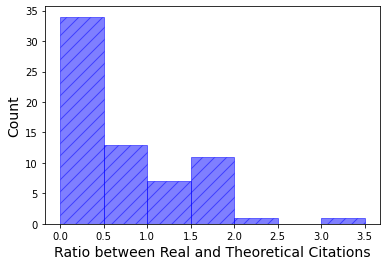

In [23]:
plt.hist(df_new['ratio'], bins=bins,color='blue', edgecolor='blue', linewidth=1, hatch="//",
         histtype='bar', alpha=0.5)
plt.xlabel('Ratio between Real and Theoretical Citations',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

## Bottom 10 "marginalized papers" with non-zero ratio between real and expected citations

In [24]:
df_new.loc[df_new['ratio'] !=0].sort_values(by='ratio').head(10)

,name,real_citation_count,expected_citation_count,year,ratio
18,Dick,1,8.049,2007,0.124
19,Kraus,1,8.049,2007,0.124
32,Lotrich,1,6.256,2008,0.160
0,Mossner,5,20.516,2001,0.244
40,Kim_b,1,4.067,2009,0.246
46,Coventry,1,4.067,2009,0.246
45,Gibb,1,4.067,2009,0.246
28,Kilpatrick,2,8.049,2007,0.248
35,PhillipsBute,2,6.256,2008,0.320
29,Bull,2,6.256,2008,0.320


## Old method (Fu, Yuan, and Schneider, 2021)

In [25]:
df_old = pd.DataFrame({'name': g.vs['name'], 'real_citation_count': g.degree(mode='in'),'expected_citation_count': g_full.degree(mode='in')})
df_old['year'] = g.vs['Year']

In [26]:
df_old.loc[df_old['expected_citation_count'] != 0,'ratio'] = df_old.loc[df_old['expected_citation_count'] != 0,'real_citation_count']/df_old.loc[df_old['expected_citation_count'] != 0,'expected_citation_count']
df_old['ratio'] = round(df_old['ratio'],3)

## Bottom 10 "marginalized papers" with non-zero ratio between real and expected citations

In [27]:
df_old.loc[df_old['ratio'] !=0].sort_values(by='ratio').head(10)

,name,real_citation_count,expected_citation_count,year,ratio
19,Kraus,1,44,2007,0.023
18,Dick,1,44,2007,0.023
32,Lotrich,1,36,2008,0.028
46,Coventry,1,25,2009,0.040
45,Gibb,1,25,2009,0.040
40,Kim_b,1,25,2009,0.040
28,Kilpatrick,2,44,2007,0.045
53,Sugden,1,18,2010,0.056
35,PhillipsBute,2,36,2008,0.056
29,Bull,2,36,2008,0.056


## Further Investigation of Ranking Robustness

In [28]:
df_old_temp = df_old.loc[(df_old['ratio'] !=0) & (df_old['expected_citation_count'] !=0), ['name','year','real_citation_count','ratio']]
df_new_temp = df_new.loc[(df_new['ratio'] !=0) & (df_new['expected_citation_count'] !=0), ['name','ratio']]

In [29]:
df_full = df_old_temp.merge(df_new_temp, how='outer', on='name',suffixes = ('_old','_new'))
df_full['rank_pure_citation'] = df_full['real_citation_count'].rank(method='average')
df_full['rank_old'] = df_full['ratio_old'].rank(method='average')
df_full['rank_new'] = df_full['ratio_new'].rank(method='average')
# update name label to include year
df_full['name'] = [x + '_' + str(y) for x, y in zip(df_full['name'], df_full['year'])]
rank_old = df_full['ratio_old']
rank_new = df_full['ratio_new']

In [30]:
df_full['rank_change'] = df_full['rank_old'] - df_full['rank_new']
df_full.head(5)

,name,year,real_citation_count,ratio_old,ratio_new,rank_pure_citation,rank_old,rank_new,rank_change
0,Mossner_2001,2001,5,0.069,0.244,28.0,11.0,4.0,7.0
1,Caspi_2003,2003,65,0.915,3.168,53.0,53.0,53.0,0.0
2,Eley_2004,2004,37,0.552,1.998,52.0,52.0,51.0,1.0
3,Grabe_a_2004,2004,21,0.313,1.134,47.0,45.0,35.0,10.0
4,Kaufman_a_2004,2004,27,0.403,1.458,49.0,49.0,39.0,10.0


In [31]:
# linear regression
import statsmodels.formula.api as smf
formula = 'rank_change ~ year'
model = smf.ols(formula, data=df_full)
result = model.fit()
result.summary()
## year is a significant predicator for rank_change

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rank_change   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     69.07
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           4.76e-11
Time:                        20:10:02   Log-Likelihood:                -141.33
No. Observations:                  53   AIC:                             286.7
Df Residuals:                      51   BIC:                             290.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3773.2691    454.018      8.311      0.000    2861.790    4684.748
year          -1.8798      0.226     -8.311      0.000      -2.334      -1.426
==============================================================================
Omnibus:                        5.886   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                3.008
Skew:                          -0.339   Prob(JB):                        0.222
Kurtosis:                       2.051   Cond. No.                     1.87e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

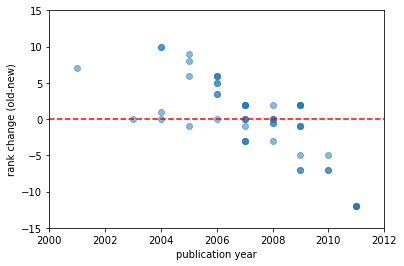

In [38]:
# plot year versus difference in ranking
rank_change = df_full['rank_change']
year = df_full['year']
plt.scatter(year, rank_change,alpha=0.5)
plt.xlabel('publication year')
plt.ylabel('rank change (old-new)')
plt.xlim(2000,2012)
plt.ylim(-15,15)
plt.axhline(y=0, color='red', linestyle='--')

Text(0, 0.5, 'rank new')

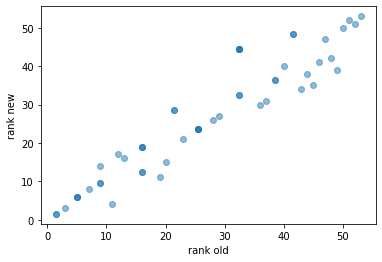

In [43]:
plt.scatter(df_full['rank_old'], df_full['rank_new'],alpha=0.5)
plt.xlabel('rank old')
plt.ylabel('rank new')

In [41]:
formula = 'rank_new ~ rank_old'
model = smf.ols(formula, data=df_full)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rank_new   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     379.3
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           2.85e-25
Time:                        20:53:32   Log-Likelihood:                -163.22
No. Observations:                  53   AIC:                             330.4
Df Residuals:                      51   BIC:                             334.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6292      1.497      1.088      0.282      -1.376       4.634
rank_old       0.9397      0.048     19.474      0.000       0.843       1.037
==============================================================================
Omnibus:                        5.238   Durbin-Watson:                   0.598
Prob(Omnibus):                  0.073   Jarque-Bera (JB):                4.363
Skew:                           0.685   Prob(JB):                        0.113
Kurtosis:                       3.317   Cond. No.                         63.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

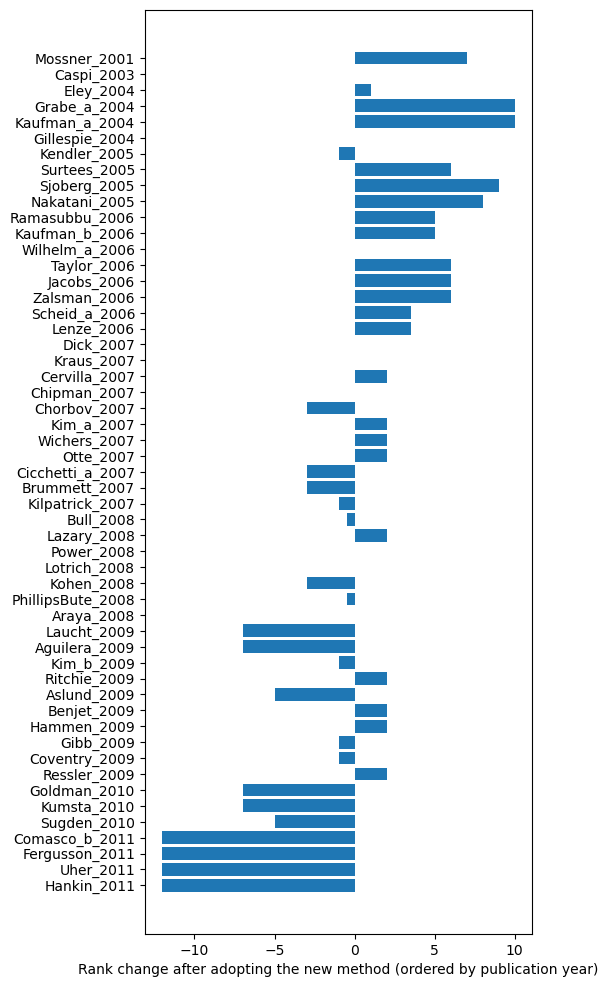

In [34]:
## make single bar-plot

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
label = df_full['name']
y_pos = np.arange(len(label))
ax.barh(y_pos, rank_change, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Rank change after adopting the new method (ordered by publication year)')

fig.set_size_inches(5, 12)

plt.show()

### Explain Ranking Robustness

A coincident. Most papers get few but non-zero citations were published in the year 2007 to 2009. They were the least affected by the change of algorithm.

Ealier and latter papers were the most impacted by the change of algorithm,which explains why Mossner_2001 was quite disruptive in term of the ranking. It is an earlier paper and recieved few citations. 

## Creating Bias Heuristic

**Marginalized Papers**

- Dick_2007
- Kraus_2007
- Lotrich_2008
- Mossner_2001
- Kim_b_2009
- Coventry_2009
- Gibb_2009
- Kilpatrick_2007
- PhillipsBute_2008
- Bull_2009

In [49]:
mp_l = ['Dick','Kraus','Lotrich','Mossner', 'Kim_b', 'Coventry', 'Gibb', 'Kilpatrick', 'PhillipsBute', 'Bull' ]
df_rec = pd.DataFrame(columns=['marginalized_paper','citing_papers'])

In [51]:
for mp_name in mp_l:
    # name of the marginalized paper
    citing_id_l = g.neighbors(g.vs.find(name_eq = mp_name),mode='in')
    citing_papers_l = []
    for citing_id in citing_id_l:
        citing_papers_l.append(g.vs[citing_id]['name'] + '_' + str(g.vs[citing_id]['Year']))
    df_rec = df_rec.append({'marginalized_paper': mp_name, 'citing_papers': citing_papers_l},ignore_index=True)

df_rec

,marginalized_paper,citing_papers
0,Dick,[Carli_2011]
1,Kraus,[Lotrich_2008]
2,Lotrich,[Sen_2010]
3,Mossner,"[Lenze_2006, Otte_2007, Zhang_b_2009, Kim_b_20..."
4,Kim_b,[Sen_2010]
5,Coventry,[Carli_2011]
6,Gibb,[Hankin_2011]
7,Kilpatrick,"[Gibb_2009, Grabe_b_2012]"
8,PhillipsBute,"[Grassi_2010, Sen_2010]"
9,Bull,"[Ressler_2009, Wilhelm_b_2012]"


## Papers citing "marginalized papers"

**Carli_2011(negative): cited Dick_2007 and Conventry_2009 (2)**

Lotrich_2008: cited Kraus_2007 (1)

**Sen_2010(positive): cited Lotrich_2008, Kim_b_2009, and PhillipsBute_2008 (3)**

Lenze_2006: cited Mossner_2001(1)

Otte_2007: cited Mossner_2001(1)

Zhang_b_2009: cited Mossner_2001(1)

Kim_b_2009: cited Mossner_2001(1)

**Wilhelm_b_2012(negative): cited Mossner_2001 and Bull_2009 (2)**

Hankin_2011: cited Gibb_2009 (1)

Gibb_2009: cited Kilpatrick_2007 (1)

Grabe_b_2012(negative): cited Kilpatrick_2007 (1)

Grassi_2010: cited PhillipsBute_2008 (1)

Ressler_2009: cited Bull_2009 (1)